In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU.')
else:
    print('Training on GPU.')

Training on GPU.


In [1]:
import pandas as pd
import numpy as np

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [4]:
from torchvision import datasets, transforms


In [7]:
path = '/home/joshi-mukul/Documents/scripts_project/training_data_preprocessed/'

In [8]:
transform = transforms.Compose([transforms.Resize((128,128)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
dataset = datasets.ImageFolder(path, transform= transform)

In [10]:
len(dataset)

34153

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


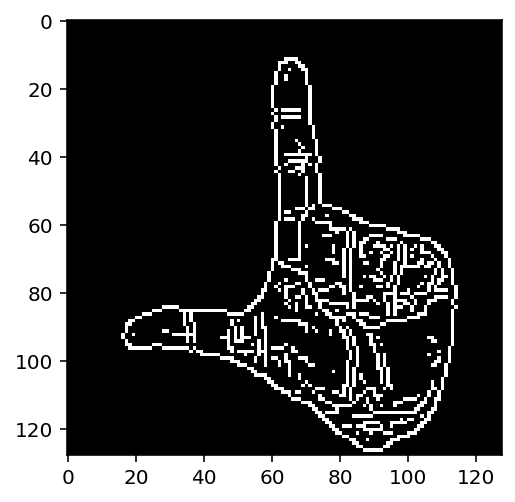

In [39]:
plt.imshow(np.transpose(dataset[20000][0].numpy(), (1, 2, 0)))


In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
images, labels = next(iter(dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


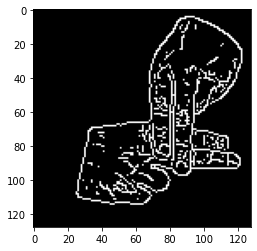

In [15]:
plt.imshow(np.transpose(images[13].numpy(), (1, 2, 0)))


In [16]:
train_transforms = transforms.Compose([transforms.Resize((128,128)),
                                #transforms.RandomRotation(30),
                                #transforms.CenterCrop(115,115),
                                #transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [17]:
val_transforms = transforms.Compose([transforms.Resize((128,128)),
                                      #transforms.CenterCrop(224),
                                      #transforms.RandomRotation(30),
                                      #transforms.CenterCrop(115,115),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [18]:
test_transforms = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [19]:
path

'/home/joshi-mukul/Documents/scripts_project/training_data_preprocessed/'

In [20]:
train_data = datasets.ImageFolder(path ,  
                                    transform=train_transforms) 
val_data = datasets.ImageFolder('/home/joshi-mukul/Documents/scripts_project/validation_data_preprocessed/', transform=val_transforms)                                      
test_data = datasets.ImageFolder('/home/joshi-mukul/Documents/scripts_project/test_data_preprocessed/', 
                                    transform=test_transforms)

In [21]:
len(train_data), len(val_data), len(test_data)

(34153, 7091, 1410)

In [22]:
trainloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=64)
valloader = torch.utils.data.DataLoader(val_data,
                                                   batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [23]:
testloader.dataset

Dataset ImageFolder
    Number of datapoints: 1410
    Root location: /home/joshi-mukul/Documents/scripts_project/test_data_preprocessed/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [24]:
dataset[0][0].shape

torch.Size([3, 128, 128])

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 500)
        self.fc2 = nn.Linear(500, 36)
        #self.fc3 = nn.Linear(84, 36)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 64*16*16)
        #print(x.shape)
        x = self.dropout(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.dropout(x)
        x = (self.fc2(x))
        #x = self.dropout(x)
        #x = self.fc3(x)
        return x


model = Net()
print(model)

model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=36, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=36, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [28]:
import os
os.chdir('/home/joshi-mukul/Documents/Models_saved')

In [29]:
pwd

'/home/joshi-mukul/Documents/Models_saved'

In [31]:
n_epochs = 35
training_loss = []
validation_loss = []

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in trainloader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

    print('training complted for epoch',epoch)

    model.eval()
    for data, target in valloader:
    #print(data.shape)

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(testloader.sampler)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Model_ISL_Mark1.pt')
        valid_loss_min = valid_loss



training complted for epoch 1
Epoch: 1 	Training Loss: 2.002900 	Validation Loss: 30.336008
Validation loss decreased (inf --> 30.336008).  Saving model ...
training complted for epoch 2
Epoch: 2 	Training Loss: 1.159316 	Validation Loss: 25.259248
Validation loss decreased (30.336008 --> 25.259248).  Saving model ...
training complted for epoch 3
Epoch: 3 	Training Loss: 0.476268 	Validation Loss: 20.140605
Validation loss decreased (25.259248 --> 20.140605).  Saving model ...
training complted for epoch 4
Epoch: 4 	Training Loss: 0.279652 	Validation Loss: 17.523771
Validation loss decreased (20.140605 --> 17.523771).  Saving model ...
training complted for epoch 5
Epoch: 5 	Training Loss: 0.181324 	Validation Loss: 14.773141
Validation loss decreased (17.523771 --> 14.773141).  Saving model ...
training complted for epoch 6
Epoch: 6 	Training Loss: 0.114280 	Validation Loss: 11.620976
Validation loss decreased (14.773141 --> 11.620976).  Saving model ...
training complted for epoch 

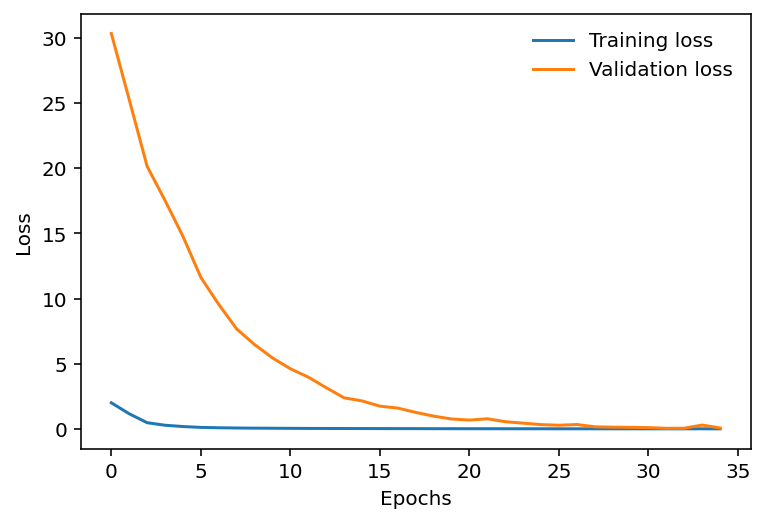

In [32]:
%config InlineBackend.figure_format = 'retina'

plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [33]:
classes = ['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [34]:
pwd

'/home/joshi-mukul/Documents/Models_saved'

In [35]:
model.load_state_dict(torch.load('Model_ISL_Mark1.pt'))

<All keys matched successfully>

In [36]:
test_loss = 0.0
class_correct = list(0. for i in range(36))
class_total = list(0. for i in range(36))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #print('runs')
    #print(len(target))
    for i in range(len(target)):
        label = target.data[i]
        #print(label)
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

print(class_total)
print(class_correct)
for i in range(36):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.007283

[10.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]
[10.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 39.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]
Test Accuracy of     0: 100% (10/10)
Test Accuracy of     1: 100% (40/40)
Test Accuracy of     2: 100% (40/40)
Test Accuracy of     3: 100% (40/40)
Test Accuracy of     4: 100% (40/40)
Test Accuracy of     5: 100% (40/40)
Test Accuracy of     6: 100% (40/40)
Test Accuracy of     7: 100% (40/40)
Test Accuracy of     8: 100% (40/40)
Test Accuracy of     9: 100% (40/40)
Test Accuracy of     A: 100% (40/40)
Test Accuracy of     B: 97% (39/40)
Test Accuracy of     C: 100% (40/40)
Test Accuracy of     D: 100% (40/40)
Test Accuracy of     E: 100%

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


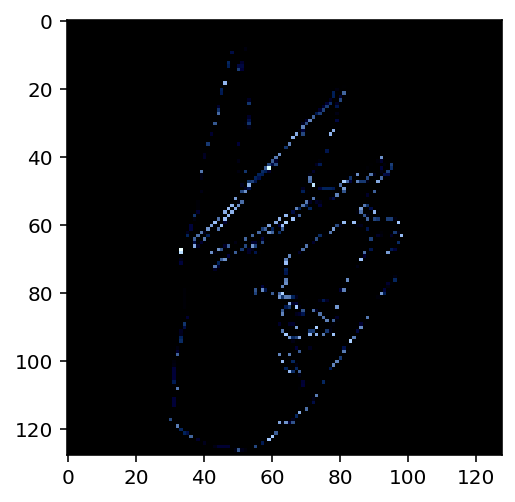

In [37]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(len(images))
# print images
plt.imshow(np.transpose(images[63].numpy(), (1, 2, 0)))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:      0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0


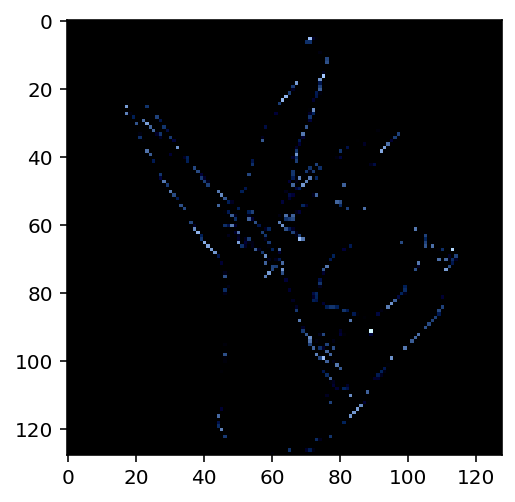

In [38]:
plt.imshow(np.transpose(images[39].numpy(), (1, 2, 0)))

#pylab.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [40]:
import torch.onnx

In [41]:
onnx_model_path = 'new_onxx_model_V1'

In [43]:
model.eval()

dummy_input = torch.randn(1,3,128,128)
dummy_input = dummy_input.cuda()
torch.onnx.export(model, dummy_input, onnx_model_path, verbose=True) 

graph(%input.1 : Float(1:49152, 3:16384, 128:128, 128:1, requires_grad=0, device=cuda:0),
      %conv1.weight : Float(16:27, 3:9, 3:3, 3:1, requires_grad=1, device=cuda:0),
      %conv1.bias : Float(16:1, requires_grad=1, device=cuda:0),
      %conv2.weight : Float(32:144, 16:9, 3:3, 3:1, requires_grad=1, device=cuda:0),
      %conv2.bias : Float(32:1, requires_grad=1, device=cuda:0),
      %conv3.weight : Float(64:288, 32:9, 3:3, 3:1, requires_grad=1, device=cuda:0),
      %conv3.bias : Float(64:1, requires_grad=1, device=cuda:0),
      %fc1.weight : Float(500:16384, 16384:1, requires_grad=1, device=cuda:0),
      %fc1.bias : Float(500:1, requires_grad=1, device=cuda:0),
      %fc2.weight : Float(36:500, 500:1, requires_grad=1, device=cuda:0),
      %fc2.bias : Float(36:1, requires_grad=1, device=cuda:0)):
  %11 : Float(1:262144, 16:16384, 128:128, 128:1, requires_grad=1, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%in

In [44]:
import cv2


In [51]:
net = cv2.dnn.readNetFromONNX(onnx_model_path)
image = cv2.imread('/home/joshi-mukul/Documents/scripts_project/test_data_new/E/31.jpg')
blob = cv2.dnn.blobFromImage(image, 1.0, (128,128), swapRB=False, crop=False)
net.setInput(blob)
preds = net.forward()
biggest_pred_index = np.array(preds)[0].argmax()
print ("Predicted class:",biggest_pred_index)

Predicted class: 14
